<a href="https://colab.research.google.com/github/zenon10/POC-OCR/blob/main/NER_bert_rg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## option 1
https://towardsdatascience.com/19-entities-for-104-languages-a-new-era-of-ner-with-the-deeppavlov-multilingual-bert-1bfa6d413ea6

In [ ]:
import sys
!{sys.executable} -m pip install --user deeppavlov

In [ ]:
!pip install pytorch-crf

In [ ]:
from torchcrf import CRF

In [ ]:
from deeppavlov import configs, build_model

ner_model = build_model(configs.ner.ner_ontonotes_bert_mult, download=True)

In [ ]:
ner_model(['Business Publications \n Le Contrat de Vente International '])

In [ ]:
ner_model(["Business Publications \n Le Contrat de Vente International est utilisé par des sociétés implantées dans différents pays pour la vente et l’achat de marchandises. L’exportateur (vendeur) s'engage à livrer certains produits et l’importateur (acheteur) s'engage à les acquérir dans les conditions de paiement" ])

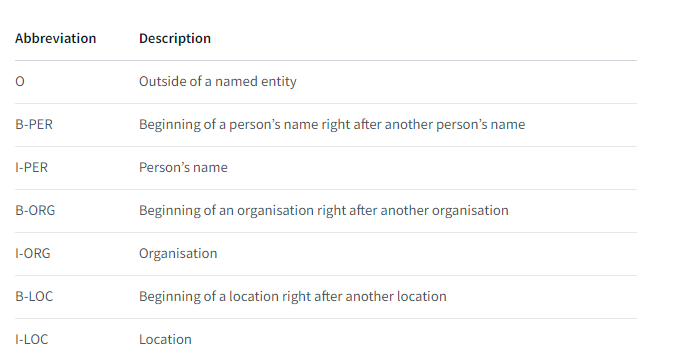

## Option 2
https://medium.com/@andrewmarmon/fine-tuned-named-entity-recognition-with-hugging-face-bert-d51d4cb3d7b5

In [ ]:
!git clone https://github.com/leslie-huang/UN-named-entity-recognition

In [ ]:
directory= '/content/UN-named-entity-recognition/tagged-training'
df = pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
df.head()

In [ ]:
!pip install transformers
!pip install datasets
!pip install seqeval

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

label_list = ['O','B-MISC','I-MISC','B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC']
label_encoding_dict = {'I-PRG': 2,'I-I-MISC': 2, 'I-OR': 6, 'O': 0, 'I-': 0, 'VMISC': 0, 'B-PER': 3, 'I-PER': 4, 'B-ORG': 5, 'I-ORG': 6, 'B-LOC': 7, 'I-LOC': 8, 'B-MISC': 1, 'I-MISC': 2}

task = "ner" 
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def get_all_tokens_and_ner_tags(directory):
    return pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
    
def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split('\t')[0] for x in y] for y in split_list]
        entities = [[x.split('\t')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})
  
def get_un_token_dataset(train_directory, test_directory):
    train_df = get_all_tokens_and_ner_tags(train_directory)
    test_df = get_all_tokens_and_ner_tags(test_directory)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return (train_dataset, test_dataset)

train_dataset, test_dataset = get_un_token_dataset('./UN-named-entity-recognition/tagged-training/', './UN-named-entity-recognition/tagged-test/')

In [ ]:
train_dataset

In [ ]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)

In [ ]:
train_tokenized_datasets

Each token has now been transformed into a numeric representation and each label has been mapped to those used in upstream training, all in Hugging Face data format.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=1e-5,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    
trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
trainer.save_model('un-ner.model')

In [ ]:
!wandb login --relogin '929b46c4abde3e31a2efcf8ebb022177b97c80e1'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

paragraph = '''Before proceeding further, I should like to inform members that action on draft resolution iv, entitled situation of human rights of Rohingya Muslims and other minorities in Myanmar is postponed to a later date to allow time for the review of its programme budget implications by the fifth committee. The assembly will take action on draft resolution iv as soon as the report of the fifth committee on the programme budget implications is available. I now give the floor to delegations wishing to deliver explanations of vote or position before voting or adoption.'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))
preds = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
preds = torch.argmax(preds.logits.squeeze(), axis=1)
predictions = [label_list[i] for i in preds]

words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')